In [618]:
import numpy as np
import random
import pandas as pd
import math
import os
import seaborn as sns
import geopandas as gdp
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
import geopandas as gpd
from geopandas.geoseries import Point

plt.rcParams['figure.dpi'] = 100
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Features

In [3]:
def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 

    if normalized == 1: distr = distr/float(np.sum(distr)) 

    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())


def getBinnedDistribution(x, y, nbins):

    n, bins = np.histogram(x, bins=nbins)
    sy, _   = np.histogram(x, bins=nbins, weights=y)
    mean    = sy/n

    return _, mean

In [104]:
features = pd.read_csv('senior_venues_features_labels.csv', sep = '\t', index_col = 0)

demo_off  = []#['WHERE_' +  w for w in ['PercLev4Qu', 'z_PercLev4Qu',  'zt_MedHPrice', 'IncomeScor', 'z_IncomeScor', 'GiniSimpso', 'zt_GiniSimpso', 'NotBornUK', 'z_NotBornUK_ratio', 'zt_PopDen', 'LivingEnSc', 'z_LivingEnSc', 'NoFlats', 'PTALScore', 'zt_PTALScore', 'EntireAirb', 'zt_ArtsEmploy_ratio', 'NoHotels', 'NoEmployee',  'No4sqCheck', 'NoOSPOIs', 'zt_NoOSPOIs', 'zt_NoEmployee_ratio','NoOwndDwel', 'z_NoOwndDwel_ratio', 'NoHouses', 'z_NoHouses_ratio','z_distCent1', 'zt_GrenSpace',  'zt_NoPropsSld',  'zt_NoCTFtoH']]
user_nw   = [u for u in features.keys() if 'WHO_u' in u]
user_succ = [u for u in features.keys() if 'tipCount' in u or 'checkinsCount' in u or 'usersCount' in u or 'Llikecount' in u or 'lLondon' in u]

features  = features.drop(columns = demo_off + user_nw + user_succ)
features  = features.drop(columns = [c for c in features.keys() if '_inv_' in c])
features  = features.drop(columns = [c for c in features.keys() if '_grav_' in c])
features  = features.dropna()

features  = features.drop(columns = ['WHO_v_social_stretch', 'WHO_v_social_std'])

print list(features.keys())

['WHERE_sub_region', 'WHERE_distance_from_center', 'WHERE_building', 'WHERE_food', 'WHERE_na', 'WHERE_travel', 'WHERE_Venues_num', 'WHERE_user_centroids', 'WHERE_parks_outdoors', 'WHERE_Entropy', 'WHERE_nightlife', 'WHAT_venue_subcat', 'WHAT_venue_cat', 'WHERE_shops', 'WHERE_education', 'WHERE_event', 'WHERE_arts_entertainment', 'WHAT_pricerange', 'WHO_m_entropy', 'WHO_m_avg', 'WHO_m_4_fraction', 'WHO_m_std', 'WHO_m_2_fraction', 'WHO_m_3_fraction', 'WHO_m_1_fraction', 'WHO_fraction_of_regulars', 'WHERE_ArtsEmploy', 'WHERE_BornUK', 'WHERE_DistCentre', 'WHERE_EntireAirb', 'WHERE_GiniSimpso', 'WHERE_GrenSpace', 'WHERE_HapScore', 'WHERE_IMDScore', 'WHERE_IncomeScor', 'WHERE_LivingEnSc', 'WHERE_MedHPrice', 'WHERE_No4sqCheck', 'WHERE_NoCTFtoH', 'WHERE_NoDwelling', 'WHERE_NoEmployee', 'WHERE_NoFlats', 'WHERE_NoHotels', 'WHERE_NoHouses', 'WHERE_NoOSPOIs', 'WHERE_NoOwndDwel', 'WHERE_NoPropsSld', 'WHERE_NotBornUK', 'WHERE_PTALScore', 'WHERE_PercLev4Qu', 'WHERE_PopDen', 'WHERE_z_distCent1', 'WHER

In [105]:
len(features.keys())

105

### Dropping features

In [ ]:
corr = features.drop(columns = ['LABEL_category']).corr()

In [ ]:
plt.matshow(corr)

In [ ]:
f, ax          = plt.subplots(1,1,figsize=(15,6))
linkage_matrix = linkage(corr, "single")
ddendrogram    = dendrogram(linkage_matrix, color_threshold=1)

In [10]:
n = len(corr)
cluster_dict = dict()
for i in range(0, n-1):
    new_cluster_id = n+i
    old_cluster_id_0 = linkage_matrix[i, 0]
    old_cluster_id_1 = linkage_matrix[i, 1]
    combined_ids = list()
    if old_cluster_id_0 in cluster_dict:
        combined_ids += cluster_dict[old_cluster_id_0]
        del cluster_dict[old_cluster_id_0]
    else:
        combined_ids += [old_cluster_id_0]
    if old_cluster_id_1 in cluster_dict:
        combined_ids += cluster_dict[old_cluster_id_1]
        del cluster_dict[old_cluster_id_1]
    else:
        combined_ids += [old_cluster_id_1]
    cluster_dict[new_cluster_id] = combined_ids
    nc =  len(cluster_dict)
    nn = sum([len(v) for v in cluster_dict.values()])
    
    if nn == 75:
  
        for cluster, values in cluster_dict.items():
            
            print nc, [corr.keys()[int(i)] for i in values]
            
        break

NameError: name 'corr' is not defined

In [108]:
features_to_keep = [
    'WHERE_IMDScore',
    'WHO_v_wa_constraint',
    'WHO_v_wa_clustering',
    'WHERE_DistCentre',
    'WHO_m_avg',
    'WHAT_pricerange',
    'WHERE_emb_own_cat',
    'WHO_fraction_of_regulars',
    'LABEL_category'
]

features2 = features#.drop(columns = [c for c in features.keys() if c not in features_to_keep])
print len(features.keys()), len(features2.keys()), len(features2)
features2.head()

105 105 8183


,WHERE_sub_region,WHERE_distance_from_center,WHERE_building,WHERE_food,WHERE_na,WHERE_travel,WHERE_Venues_num,WHERE_user_centroids,WHERE_parks_outdoors,WHERE_Entropy,...,WHO_v_wa_pagerank_wa,WHO_v_wa_constraint,WHO_v_wa_betweenness_wa,WHO_v_wa_geo_social_stretch_distances,WHO_v_wa_egosize,WHO_v_wa_geo_stdev_of_ego_distances,WHO_v_wa_constraint_wa,WHO_v_wa_pagerank_exp_distances,WHO_v_wa_eigenvector,LABEL_category
venue,,,,,,,,,,,,,,,,,,,,,
4a5f9446f964a520e0bf1fe3,0,4.064099,0.175676,0.280405,0.010135,0.187500,592,192,0.043919,0.811208,...,0.000014,1.0,0.0,2.019477,2.0,0.0,1.0,0.000019,0.0,1
4abcec53f964a520b98720e3,0,0.232250,0.202420,0.303504,0.009327,0.072473,7934,4835,0.043988,0.827807,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1
4abdc1c7f964a5206d8b20e3,0,2.306181,0.317386,0.252042,0.016336,0.039090,1714,651,0.030922,0.781289,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1
4abe4502f964a520558c20e3,0,1.137742,0.202420,0.303504,0.009327,0.072473,7934,4835,0.043988,0.827807,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,5
4abe5714f964a520d68c20e3,0,0.707539,0.199941,0.273588,0.016169,0.053239,10143,5276,0.012620,0.770677,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1


In [109]:
firstimes = pd.read_csv('venues_firstime.csv', sep = '\t', header = None, index_col = 0)
firstimes.index.name = 'venue'
firstimes = firstimes.rename(columns = {1: 'WHEN_firsttime', 2 :'WHEN_hour_most', 3 : 'WHEN_day_most'})
firstimes = firstimes.drop(columns = [4])



genders   = pd.read_csv('venues_genders.csv', sep = '\t',  index_col = 0)
genders = genders.rename(columns = {'female': 'WHO_female_fraction'})
genders   = genders.drop(columns = ['LABEL_category'])

genders.head()

features2 = features2.join(firstimes)
features2 = features2.join(genders)

print len(features2.keys()), len(features2)
features2.head()

features2.head()


firstimes.head()

109 8183


,WHEN_firsttime,WHEN_hour_most,WHEN_day_most
venue,,,
4b6b2e67f964a520f6f72be3,1.339057e+09,0,3
4b49fe9ef964a520767726e3,1.385822e+09,11,5
4bf2444670779521e1ae3e7c,1.353626e+09,7,4
4b5494c1f964a5200ac127e3,1.345742e+09,9,0
4bc1d838920eb71326301b2c,1.379445e+09,8,6


In [ ]:
corr2 = features2.drop(columns = ['LABEL_category']).corr()
plt.matshow(corr2)

### Sampling venues

In [110]:
outfolder  = 'Figures/datafiles/'
files      = [outfolder + f for f in os.listdir(outfolder) if 'clusters_data_all_' in f]
indicies   = [(i,j) for i in range(2) for j in range(3)]
clusters   = [fn.split('_')[3].replace('.dat', '') for fn in files] 
N          = 160

clusters_venues = {}
for cluster in clusters:
    clusters_venues[cluster] = []
    for ind, line in enumerate(open(outfolder + '/sorted_dist/sorted_dist_venues_in_' + cluster + '.dat')):
        if ind == N: break
        clusters_venues[cluster].append(line.strip().split('\t')[0])


top100venues = []
for c, vens in clusters_venues.items():
    
    top100venues += vens
    

print clusters_venues.keys()
features3 = features2[features2.index.isin(top100venues)]    
print len(features), len(features2), len(features3.keys()), len(features3)

features3 = features3.dropna()


features2.to_csv('FINAL_FEATURES_UNCORR_BALANCED_ALL.csv', '\t')
features3.to_csv('FINAL_FEATURES_UNCORR_BALANCED_160.csv', '\t')

features3.head()


#['fallandrise', 'rise', 'ephemeral', 'riseandfall', 'fall', 'underdogs']


pd.DataFrame(features3.drop_duplicates(subset=['LABEL_category'], keep='last').LABEL_category)



clustersids = {3: 'rise',
                2: 'fallandrise ',
                0: 'ephemeral',
                1: 'fall',
                4: 'riseandfall',
                5: 'underdogs'}


['fallandrise', 'rise', 'ephemeral', 'riseandfall', 'fall', 'underdogs']
8183 8183 109 960


# SKLEARN  CLASSIFICATION

In [ ]:
#def classifiers(XX, yy, randomized):
      
#    if randomized: random.shuffle(yy) 
    
#    classifier = RandomForestClassifier(max_depth=3, n_estimators=1000, max_features='auto') 
    #classifier = GaussianNB()
    #classifier = SVC()

 #   X_train, X_test, y_train, y_test =  train_test_split(XX, yy, test_size=.53, random_state=42, stratify = y)
  #  classifier.fit(X_train, y_train)

   # print  classifier.score(X_test, y_test)


In [112]:
X = features3.drop(columns = ['LABEL_category'])
y = np.asarray(features3.LABEL_category)

In [ ]:
classifiers(X, y, False)

# XGBOOST CLASSIFICATION

In [113]:
def xgb_model_params(X, y, max_depth_, learning_rate_, subsample_):
     
        
    train_data, test_data, train_label, test_label =  train_test_split(X, y, test_size=.33, random_state=42)            
        
    model2       = xgb.XGBClassifier(n_estimators=100, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
    
    return accuracy_score(test_label, pred2) * 100


xgb_model_params(X, y, 5, 0.0001, 0.8)

29.18032786885246

In [114]:
def xgb_model_params_importance(X, y, max_depth_, learning_rate_, subsample_):
           
    train_data, test_data, train_label, test_label =  train_test_split(X, y, test_size=.33, random_state=42)    
           
    model2       = xgb.XGBClassifier(n_estimators=1000, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
        
    featurenames, importances = zip(*sorted(zip(train_data.keys(), model2.feature_importances_), key=lambda tup: tup[1], reverse = True))
    print accuracy_score(test_label, pred2) * 100
    
    return featurenames, importances 
 

featurenames, importances = xgb_model_params_importance(X, y, 5, 0.05, 0.75)

fout = open('FINAL_DATA/6CLASS_IMPORTANCE.dat', 'w')
for i in range(len(featurenames)):
    fout.write(featurenames[i] + '\t' + str(importances[i]) + '\n')
fout.close()

28.524590163934427


In [130]:
def xgb_model_params_types(X, y, max_depth_ ,learning_rate_, subsample_, tipus = ''):
              
    X_ = X.drop(columns = [c for c in X.keys() if tipus not in c] )  
        
    train_data, test_data, train_label, test_label =  train_test_split(X_, y, test_size=.33, random_state=42)    
          
    model2       = xgb.XGBClassifier(n_estimators=100, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
            
    print tipus, accuracy_score(test_label, pred2) * 100   
    
    featurenames, importances = zip(*sorted(zip(train_data.keys(), model2.feature_importances_), key=lambda tup: tup[1], reverse = True)[0:20])
    
    return accuracy_score(test_label, pred2) * 100, featurenames, importances
 

    
alll, featurenames_all,    importances_all  = xgb_model_params_types(X, y, 5, 0.015, 0.8, '')  
where, featurenames_where, importances_     = xgb_model_params_types(X, y, 5, 0.015, 0.8, 'WHERE')  
who, featurenames_who,     importances_     = xgb_model_params_types(X, y, 5, 0.015, 0.8, 'WHO')  
when, featurenames_when, importances_       = xgb_model_params_types(X, y, 5, 0.015, 0.8, 'WHEN')  
what, featurenames_what, importances_       = xgb_model_params_types(X, y, 5, 0.015, 0.8, 'WHAT') 

print featurenames_where

 31.475409836065577
WHERE 19.01639344262295
WHO 24.91803278688525
WHEN 22.950819672131146
WHAT 26.885245901639344
('WHERE_emb_own_cat', 'WHERE_emb_na', 'WHERE_emb_nightlife', 'WHERE_emb_building', 'WHERE_distance_from_center', 'WHERE_emb_arts_entertainment', 'WHERE_emb_education', 'WHERE_emb_parks_outdoors', 'WHERE_emb_event', 'WHERE_emb_travel', 'WHERE_emb_food', 'WHERE_emb_shops', 'WHERE_shops', 'WHERE_nightlife', 'WHERE_Venues_num', 'WHERE_travel', 'WHERE_food', 'WHERE_building', 'WHERE_na', 'WHERE_parks_outdoors')


In [ ]:
ef xgb_model_params_types_top_features(X, y, ijk, topfeats, max_depth_ ,learning_rate_, subsample_, tipus = ''):
              
    X_ = X.drop(columns = [c for c in X.keys() if c not in topfeats[0:20-ijk]] )  
        

    train_data, test_data, train_label, test_label =  train_test_split(X_, y, test_size=.33, random_state=42)    
          
    model2       = xgb.XGBClassifier(n_estimators=1, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
            
    #print tipus, accuracy_score(test_label, pred2) * 100   
            
    return accuracy_score(test_label, pred2) * 100
 
    
    

alll  = xgb_model_params_types_top_features(X, y, ijk, featurenames_all,   6, 0.01, 0.8, '')  
where = xgb_model_params_types_top_features(X, y, ijk,  featurenames_where, 6, 0.01, 0.8, 'WHERE')  
who   = xgb_model_params_types_top_features(X, y, ijk,  featurenames_who,   6, 0.01, 0.8, 'WHO')  
when  = xgb_model_params_types_top_features(X, y, ijk,  featurenames_when,  6, 0.01, 0.8, 'WHEN')  
what  = xgb_model_params_types_top_features(X, y, ijk,  featurenames_what,  6, 0.01, 0.8, 'WHAT')  




 29.18032786885246
WHERE 20.327868852459016
WHO 22.950819672131146
WHEN 24.59016393442623
WHAT 16.065573770491802
 24.91803278688525
WHERE 21.639344262295083
WHO 20.655737704918035
WHEN 22.950819672131146
WHAT 27.54098360655738
 29.18032786885246
WHERE 21.9672131147541
WHO 20.0
WHEN 22.950819672131146
WHAT 27.54098360655738
 28.196721311475407
WHERE 23.934426229508198
WHO 23.60655737704918
WHEN 22.950819672131146
WHAT 27.54098360655738
 32.131147540983605
WHERE 22.62295081967213
WHO 22.62295081967213
WHEN 22.950819672131146
WHAT 27.54098360655738
 32.131147540983605
WHERE 22.62295081967213
WHO 21.639344262295083
WHEN 22.950819672131146
WHAT 27.54098360655738
 31.475409836065577
WHERE 23.278688524590162
WHO 22.62295081967213
WHEN 22.950819672131146
WHAT 27.54098360655738
 31.80327868852459
WHERE 20.983606557377048
WHO 23.60655737704918
WHEN 22.950819672131146
WHAT 27.54098360655738
 28.524590163934427
WHERE 20.327868852459016
WHO 22.62295081967213
WHEN 22.950819672131146
WHAT 27.5409836

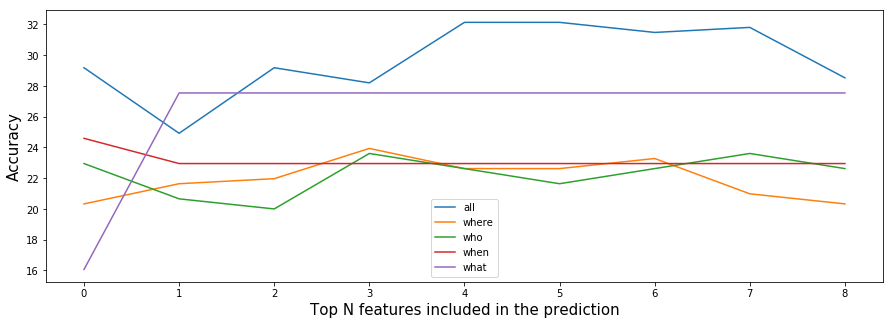

In [140]:
def xgb_model_params_types_top_features(X, y, ijk, topfeats, max_depth_ ,learning_rate_, subsample_, tipus = ''):
              
    X_ = X.drop(columns = [c for c in X.keys() if c not in topfeats[0:(20-10-ijk)]] )  
        

    train_data, test_data, train_label, test_label =  train_test_split(X_, y, test_size=.33, random_state=42)    
          
    model2       = xgb.XGBClassifier(n_estimators=100, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
            
    print tipus, accuracy_score(test_label, pred2) * 100   
            
    return accuracy_score(test_label, pred2) * 100
 
    
    
allls  = []
wheres = []
whos   = []
whens  = []
whats  = []
    
    
for ijk in reversed(range(9)):    

    allls.append(xgb_model_params_types_top_features(X,  y, ijk, featurenames_all,    6, 0.01, 0.8, '')  )
    wheres.append(xgb_model_params_types_top_features(X, y, ijk,  featurenames_where, 6, 0.01, 0.8, 'WHERE')  )
    whos.append(xgb_model_params_types_top_features(X,   y, ijk,  featurenames_who,   6, 0.01, 0.8, 'WHO')  )
    whens.append(xgb_model_params_types_top_features(X,  y, ijk,  featurenames_when,  6, 0.01, 0.8, 'WHEN')  )
    whats.append(xgb_model_params_types_top_features(X,  y, ijk,  featurenames_what,  6, 0.01, 0.8, 'WHAT')  )

    

    
f, ax = plt.subplots(1,1,figsize = (15,5)) 

ax.plot(allls,  label = 'all')
ax.plot(wheres, label = 'where')
ax.plot(whos,   label = 'who')
ax.plot(whens,  label = 'when')
ax.plot(whats,  label = 'what')

ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_xlabel('Top N features included in the prediction', fontsize = 15)
ax.legend(loc = 'best')


In [198]:
def round_unix_date(dt_series, seconds=6*30*24*60*60, up=False):
    return dt_series // seconds * seconds + seconds * up



fall   = featurenames_all[0:5]
fwhere = featurenames_where[0:4]
fwho   = featurenames_who[0:4]
fwhen  = featurenames_when[0:2]
fwhat  = featurenames_what[0:2]   

print fall
print fwhere
print fwho
print fwhen
print fwhat

new_features = list( fall ) + list( fwhere ) + list( fwho ) + list( fwhen ) + list( fwhat ) 
print set(new_features)

fall

('WHEN_firsttime', 'WHO_m_entropy', 'WHO_female_fraction', 'WHERE_emb_own_cat', 'WHO_fraction_of_regulars')
('WHERE_emb_own_cat', 'WHERE_emb_na', 'WHERE_emb_nightlife', 'WHERE_emb_building')
('WHO_m_entropy', 'WHO_female_fraction', 'WHO_fraction_of_regulars', 'WHO_m_4_fraction')
('WHEN_firsttime', 'WHEN_hour_most')
('WHAT_venue_subcat', 'WHAT_venue_cat')
set(['WHO_fraction_of_regulars', 'WHO_female_fraction', 'WHERE_emb_na', 'WHEN_firsttime', 'WHEN_hour_most', 'WHERE_emb_nightlife', 'WHO_m_entropy', 'WHAT_venue_cat', 'WHO_m_4_fraction', 'WHERE_emb_own_cat', 'WHERE_emb_building', 'WHAT_venue_subcat'])


('WHEN_firsttime',
 'WHO_m_entropy',
 'WHO_female_fraction',
 'WHERE_emb_own_cat',
 'WHO_fraction_of_regulars')

In [250]:
Xcorr = X.drop(columns = [c for c in X.keys() if c not in new_features])
corrx = Xcorr.corr()
#corr = features.drop(columns = ['LABEL_category']).corr()

for c in corrx:
    print c, '\t', max(ll for ll in list(corrx[c]) if 1.0 != ll)

WHAT_venue_subcat 	0.180658591504
WHAT_venue_cat 	0.180658591504
WHO_m_entropy 	0.204004380893
WHO_m_4_fraction 	0.17727888709
WHO_fraction_of_regulars 	0.0445712373072
WHERE_emb_building 	0.772331681067
WHERE_emb_own_cat 	0.0260667378252
WHERE_emb_na 	0.671175313763
WHERE_emb_nightlife 	0.772331681067
WHEN_firsttime 	0.0507060395196
WHEN_hour_most 	0.204004380893
WHO_female_fraction 	0.17727888709


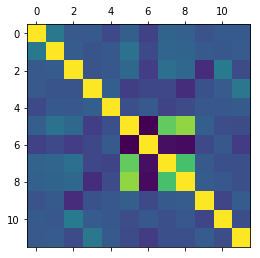

In [252]:
plt.matshow(corrx)
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/correlations_of_features.png')    



In [199]:
names    = ['alll', 'where', 'who', 'when', 'what']
results  = [alll, where, who, when, what]
results2 = [r / (1.0/6.0) - 100 for r in results]
results


[31.475409836065577,
 19.01639344262295,
 24.91803278688525,
 22.950819672131146,
 26.885245901639344]

In [200]:
fout = open('FINAL_DATA/6SHAPES_COMPARISON.dat', 'w')

for ind, r in enumerate(results2):
    fout.write(names[ind] + '\t' +  str(r) + '\n')
    print names[ind] + '\t' +  str(r)
    
fout.close()

alll	88.85245901639348
where	14.098360655737693
who	49.50819672131149
when	37.70491803278688
what	61.31147540983608


# DIFF BETWEEN CLASSES

In [146]:
features4 = features3.drop(columns = [c for c in features3.keys() if c not in list(fall) + ['LABEL_category']])
print clustersids
features4.head()

{0: 'ephemeral', 1: 'fall', 2: 'fallandrise ', 3: 'rise', 4: 'riseandfall', 5: 'underdogs'}


,WHO_m_entropy,WHO_fraction_of_regulars,WHERE_emb_own_cat,LABEL_category,WHEN_firsttime,WHO_female_fraction
venue,,,,,,
4ac51183f964a52049a020e3,0.992990,0.216110,19.345627,3,1.339332e+09,0.426357
4ac518b4f964a52067a020e3,0.989458,0.100000,16.144227,2,1.360076e+09,0.600000
4ac518b4f964a52072a020e3,0.991121,0.160000,19.605537,3,1.339444e+09,0.396429
4ac518b4f964a52073a020e3,0.989679,0.200000,16.532659,0,1.346148e+09,0.368421
4ac518b4f964a5207aa020e3,0.987350,0.071429,11.046645,5,1.372147e+09,0.346154


### First time

[0.2340195  0.34344529 0.18959913 0.13976165 0.05200433 0.0411701 ]


Text(0,0.5,'Fraction of venues comparing to the avg')

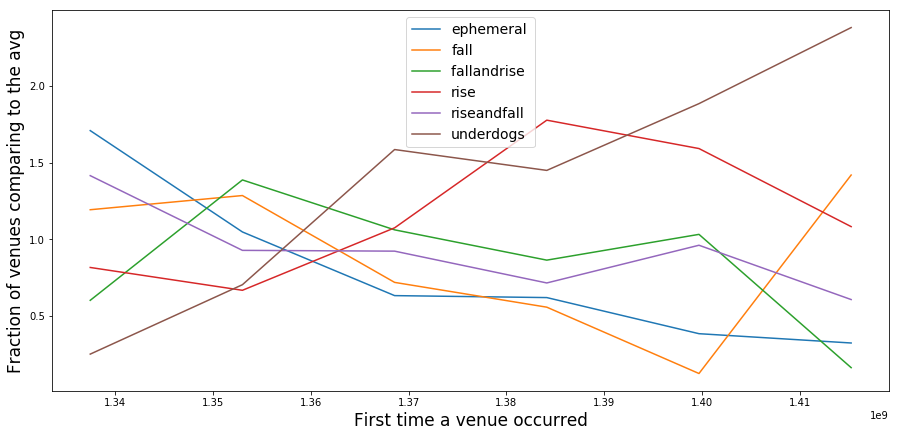

In [210]:
clusters_top_features_dist = {}


firsttimes = []
f, ax      = plt.subplots(1,1,figsize = (15,7))
sss        = []

for cl, cname in clustersids.items():   
    df_cl       = features4[features4.LABEL_category == cl]
    firsttimes  = [round_unix_date(f) for f in list(df_cl.WHEN_firsttime)]
    sss        += firsttimes
    
    
xxx, yyy = getDistribution(sss)
   
print yyy
    
for cl, cname in clustersids.items():   
    df_cl      = features4[features4.LABEL_category == cl]
    firsttimes = [round_unix_date(f) for f in list(df_cl.WHEN_firsttime)]
    x, y       = getDistribution(firsttimes)
    y          = np.asarray(y) / np.asarray(yyy)
    ax.plot(x, y, label = cname) 
   
    ax.legend(loc = 'left', fontsize = 14)
    
    
    if cname not in clusters_top_features_dist: 
        clusters_top_features_dist[cname] = {}
        
    clusters_top_features_dist[cname]['WHEN_firsttime'] = (x, y)


ax.set_xlabel('First time a venue occurred', fontsize = 17)
ax.set_ylabel('Fraction of venues comparing to the avg', fontsize = 17)    

### Money entropy

Text(0,0.5,'Fraction of venues with within the bin in given classes / all in that bin')

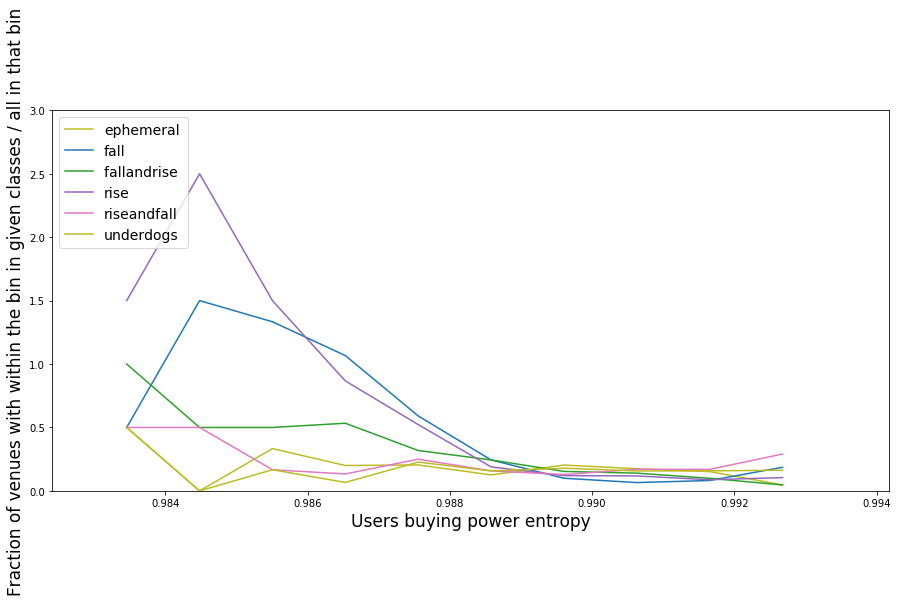

In [170]:
firsttimes = []
f, ax      = plt.subplots(1,1,figsize = (15,7))
sss        = []

for cl, cname in clustersids.items(): 
    
    df_cl      = features4[features4.LABEL_category == cl]
    entropies  = [f for f in list(df_cl.WHO_m_entropy)]
    counts, bins, bars = ax.hist(entropies, alpha = 0)
    
    bins = (bins[1:] + bins[:-1])/2 
    x    = bins
    y    = counts
    sss += entropies
    
   
Acounts, Abins, Abars = ax.hist(sss, alpha = 0)
Abins = (Abins[1:] + Abins[:-1])/2    

   
  
    
for cl, cname in clustersids.items():   
    df_cl      = features4[features4.LABEL_category == cl]
    firsttimes = [f for f in list(df_cl.WHO_m_entropy)]
    counts, bins, bars = ax.hist(firsttimes, alpha = 0)
    bins = (bins[1:] + bins[:-1])/2 
    y    = counts
    y    = y / Acounts
    
    ax.plot(x, y, label = cname) 
    ax.legend(loc = 'left', fontsize = 14)
    

    clusters_top_features_dist[cname]['WHO_m_entropy'] = (x, y)

    
    
ax.set_ylim([0,3])



ax.set_xlabel('Users buying power entropy', fontsize = 17)
ax.set_ylabel('Fraction of venues with within the bin in given classes / all in that bin', fontsize = 17) 

### Fraction of regulars

Text(0,0.5,'Fraction of...')

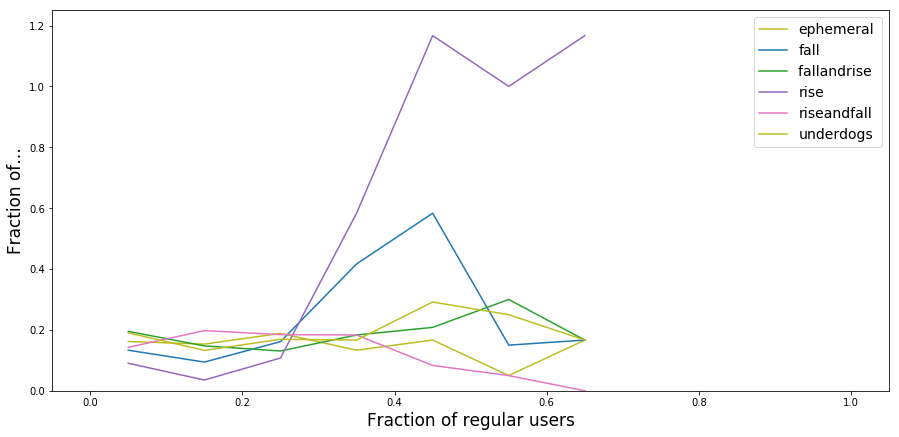

In [171]:
firsttimes = []
f, ax      = plt.subplots(1,1,figsize = (15,7))
sss        = []

for cl, cname in clustersids.items(): 
    
    df_cl      = features4[features4.LABEL_category == cl]
    entropies  = [f for f in list(df_cl.WHO_fraction_of_regulars)]
    counts, bins, bars = ax.hist(entropies, alpha = 0)
    
    bins = (bins[1:] + bins[:-1])/2 
    x    = bins
    y    = counts
    sss += entropies
    
   
   
Acounts, Abins, Abars = ax.hist(sss, alpha = 0)
Abins = (Abins[1:] + Abins[:-1])/2    

   
  
    
for cl, cname in clustersids.items():   
    df_cl      = features4[features4.LABEL_category == cl]
    firsttimes = [f for f in list(df_cl.WHO_fraction_of_regulars)]
    counts, bins, bars = ax.hist(firsttimes, alpha = 0)
    bins = (bins[1:] + bins[:-1])/2 
    y    = counts
    y    = y / Acounts
    
    ax.plot(x, y, label = cname) 
    ax.legend(loc = 'left', fontsize = 14)
    

    clusters_top_features_dist[cname]['WHO_fraction_of_regulars'] = (x, y)

    
ax.set_ylim([0,1.25])



ax.set_xlabel('Fraction of regular users', fontsize = 17)
ax.set_ylabel('Fraction of...', fontsize = 17)


### Own category embededness

Text(0,0.5,'Fraction of...')

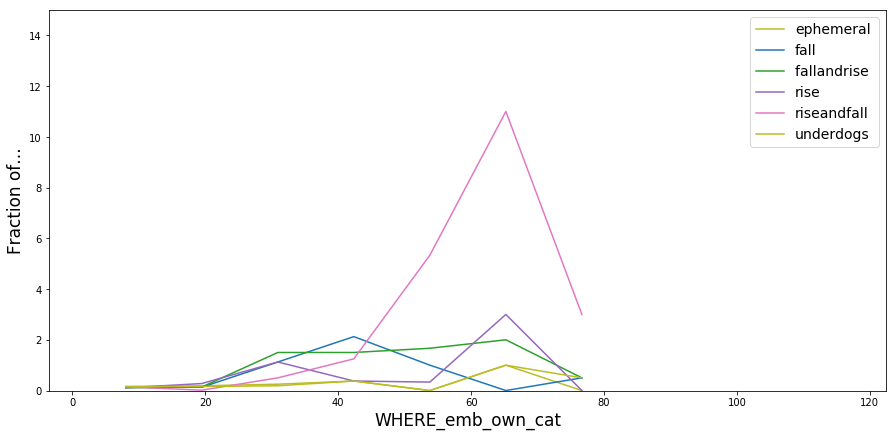

In [175]:
firsttimes = []
f, ax      = plt.subplots(1,1,figsize = (15,7))
sss        = []

for cl, cname in clustersids.items(): 
    
    df_cl      = features4[features4.LABEL_category == cl]
    entropies  = [f for f in list(df_cl.WHERE_emb_own_cat)]
    counts, bins, bars = ax.hist(entropies, alpha = 0)
    
    bins = (bins[1:] + bins[:-1])/2 
    x    = bins
    y    = counts
    sss += entropies
    
   
   
Acounts, Abins, Abars = ax.hist(sss, alpha = 0)
Abins = (Abins[1:] + Abins[:-1])/2    

   
  
    
for cl, cname in clustersids.items():   
    df_cl      = features4[features4.LABEL_category == cl]
    firsttimes = [f for f in list(df_cl.WHERE_emb_own_cat)]
    counts, bins, bars = ax.hist(firsttimes, alpha = 0)
    bins = (bins[1:] + bins[:-1])/2 
    y    = counts
    y    = y / Acounts
    
    ax.plot(x, y, label = cname) 
    ax.legend(loc = 'left', fontsize = 14)
    
    
    clusters_top_features_dist[cname]['WHERE_emb_own_cat'] = (x, y)

    

ax.set_ylim([0,15])



ax.set_xlabel('WHERE_emb_own_cat', fontsize = 17)
ax.set_ylabel('Fraction of...', fontsize = 17)

### Gender distribution

Text(0,0.5,'Fraction of...')

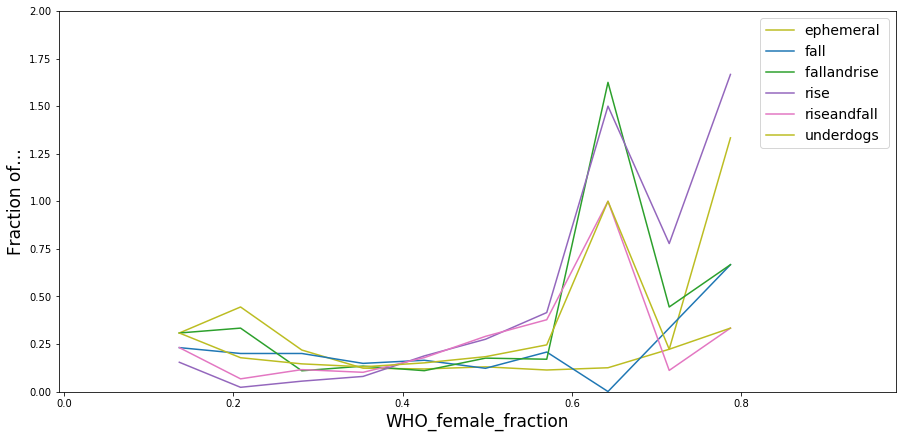

In [176]:
firsttimes = []
f, ax      = plt.subplots(1,1,figsize = (15,7))
sss        = []

for cl, cname in clustersids.items(): 
    
    df_cl      = features4[features4.LABEL_category == cl]
    entropies  = [f for f in list(df_cl.WHO_female_fraction)]
    counts, bins, bars = ax.hist(entropies, alpha = 0)
    
    bins = (bins[1:] + bins[:-1])/2 
    x    = bins
    y    = counts
    sss += entropies
    
   
   
Acounts, Abins, Abars = ax.hist(sss, alpha = 0)
Abins = (Abins[1:] + Abins[:-1])/2    

   
  
    
for cl, cname in clustersids.items():   
    df_cl      = features4[features4.LABEL_category == cl]
    firsttimes = [f for f in list(df_cl.WHO_female_fraction)]
    counts, bins, bars = ax.hist(firsttimes, alpha = 0)
    bins = (bins[1:] + bins[:-1])/2 
    y    = counts
    y    = y / Acounts
    
    ax.plot(x, y, label = cname) 
    ax.legend(loc = 'left', fontsize = 14)
    
    
    clusters_top_features_dist[cname]['WHO_female_fraction'] = (x, y)

    

ax.set_ylim([0,2])



ax.set_xlabel('WHO_female_fraction', fontsize = 17)
ax.set_ylabel('Fraction of...', fontsize = 17)



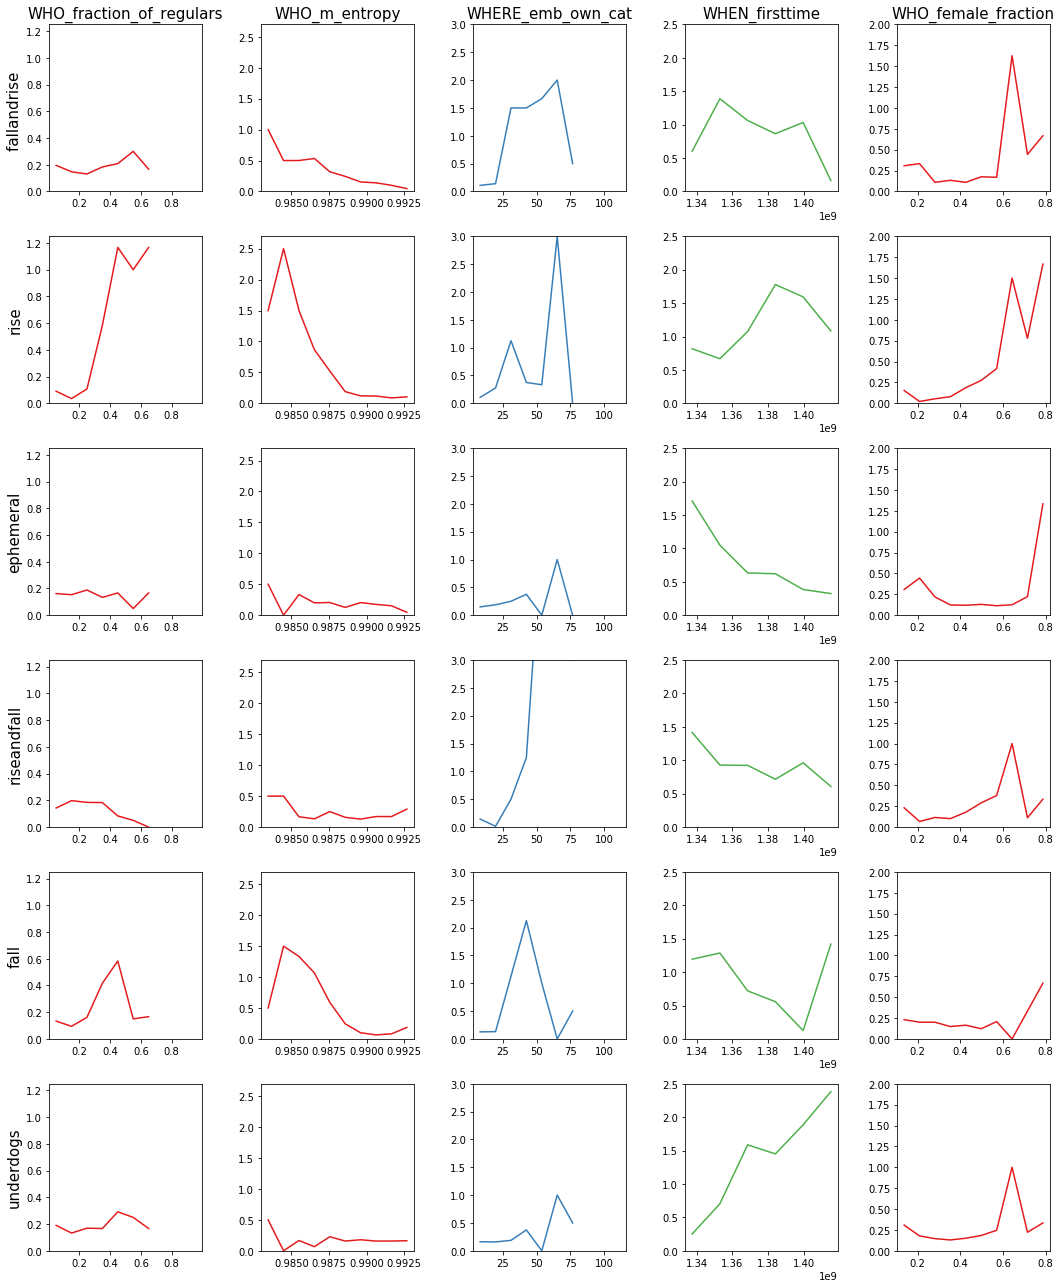

In [197]:
f, ax    = plt.subplots(6,5, figsize = (15,18))
indicies = [(i,j) for i in range(6) for j in range(5)]
ind      = 0

for cluster, data in clusters_top_features_dist.items():
 
    for featname, (x,y) in data.items():
        
        bx   = ax[indicies[ind]]
        
        if indicies[ind][0] == 0:
            bx.set_title(featname, fontsize = 15)

            
        if indicies[ind][1] == 0:
            bx.set_ylabel(cluster, fontsize = 15)            
        
        ind += 1
        
        bx.plot(x,y, color = colors_d[featname.split('_')[0]])
        

ylims = [ [ 0.0, 1.25 ], 
          [ 0.0, 2.7  ],
          [ 0.0, 3.0  ],
          [ 0.0, 2.5 ],
          [ 0.0, 2.0 ]
        ]        
        

for i in range(6):
    for j in range(5):
        ax[i,j].set_ylim(ylims[j])
    

plt.tight_layout()
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/features_comparison.png')    

# Success quantiles

In [205]:
city        = 'london'
datafile    = 'FINAL_DATA'
successdata = datafile + '/london_venues_success_measures.csv'
venues      = [line.strip() for line in open(datafile + '/senior_venues_lists.dat')]


success  = pd.read_csv(successdata, sep = '\t', index_col = 0)
success  = success[~success.index.duplicated(keep='first')]   
success  = success[success.index.isin(venues)]



successdata_L = datafile + '/london_venues_success_measures_local_like.csv'
success_L     = pd.read_csv(successdata_L, sep = '\t', index_col = 0)
success_L     = success_L[~success_L.index.duplicated(keep='first')]   
success       = success.join(success_L)

success.index.name = 'venue'

success_label = success.join(pd.DataFrame(features.LABEL_category))
success_label = success_label.dropna()  

success_label = success_label[success_label.index.isin(top100venues)]    
success_label['quartile'] = pd.qcut(success_label['Llikecount'], 4, ['q1', 'q2', 'q3', 'q4'])



print len(success_label)
success_label.head()



960


,tipCount,checkinsCount,usersCount,Llikecount,LABEL_category,quartile
venue,,,,,,
4ac51183f964a52049a020e3,197.0,18244.0,13317.0,407.534797,3.0,q4
4ac518b4f964a52067a020e3,18.0,1961.0,1030.0,6.798433,2.0,q1
4ac518b4f964a52072a020e3,68.0,13120.0,6437.0,72.147000,3.0,q4
4ac518b4f964a52073a020e3,11.0,613.0,323.0,15.068339,0.0,q2
4ac518b4f964a5207aa020e3,60.0,4135.0,1747.0,10.178994,5.0,q2


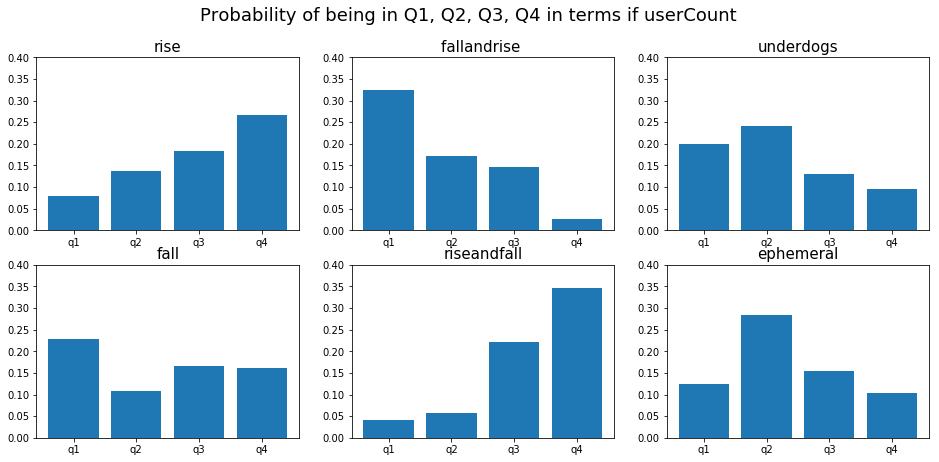

In [335]:
f, ax     = plt.subplots(2,3, figsize = (16,7))
indicies  = [(i,j) for i in range(2) for j in range(3)]
fig_order = {'rise' : 0, 'fallandrise ' : 1, 'underdogs' : 2, 'fall' : 3, 'riseandfall' : 4, 'ephemeral' : 5 }



for ind, c in clustersids.items():
    bx = ax[indicies[fig_order[c]]]
    
    df  = success_label[success_label.LABEL_category == ind]
    

    df     = df.groupby('quartile').count()
    df_all = success_label.groupby('quartile').count()
    
    
    x         = df.index
    clustered = np.asarray(df.usersCount,     dtype=np.float64)
    allv      = np.asarray(df_all.usersCount, dtype=np.float64)
    y         = clustered / allv
    
    bx.set_title(c, fontsize = 15)
    bx.bar(x, y)
    bx.set_ylim([0,0.4])
    
    
    
plt.suptitle('Probability of being in Q1, Q2, Q3, Q4 in terms if userCount', fontsize = 18)


plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/quantiles.png')    

# GEO STUFF

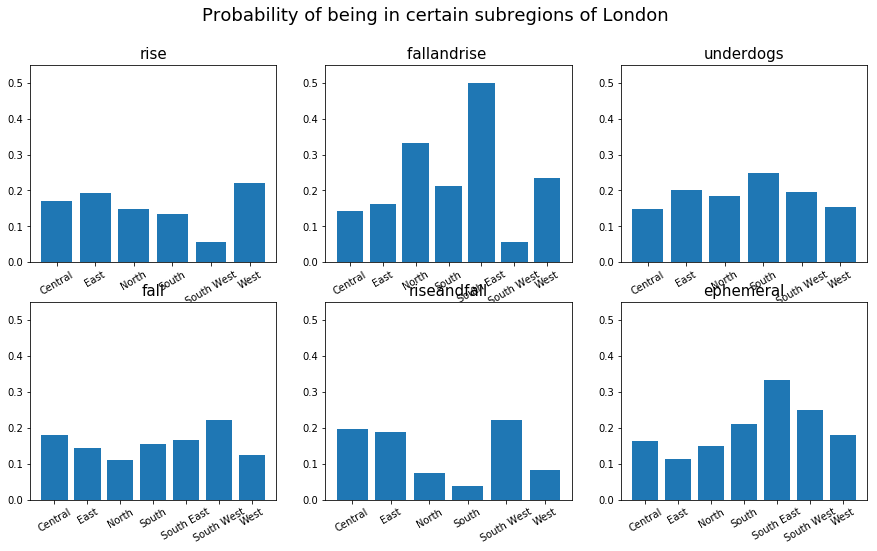

In [341]:
f, ax      = plt.subplots(2,3, figsize = (15,8))
indicies   = [(i,j) for i in range(2) for j in range(3)]
fig_order  = {'rise' : 0, 'fallandrise ' : 1, 'underdogs' : 2, 'fall' : 3, 'riseandfall' : 4, 'ephemeral' : 5 }
featuresCD = pd.DataFrame(features3[['WHERE_sub_region', 'LABEL_category']])

cardinaldirections = {  4: 'South East',
                        2: 'North',
                        5: 'South West',
                        6: 'West',
                        1: 'East',
                        3: 'South',
                        0: 'Central'}


for ind, c in clustersids.items():
    
    bx     = ax[indicies[fig_order[c]]]
    df     = featuresCD[featuresCD.LABEL_category == ind]
    df     = df.groupby('WHERE_sub_region').count()
    x      = np.asarray(df.index)
    y      = dict(df.LABEL_category)#, dtype=np.float64)
    yall   = dict(featuresCD.groupby('WHERE_sub_region').count().LABEL_category) 
    ydata  = [ float(y[xx])/float(yall[xx]) for xx in x]
    

    bx.bar([cardinaldirections[xx] for xx in x],ydata)
    bx.set_xticklabels([cardinaldirections[xx] for xx in x], rotation = 30)
    bx.set_ylim([0.0, 0.55])
    bx.set_title(c, fontsize = 15)

    
plt.suptitle('Probability of being in certain subregions of London', fontsize = 18)
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/subregions.png')    

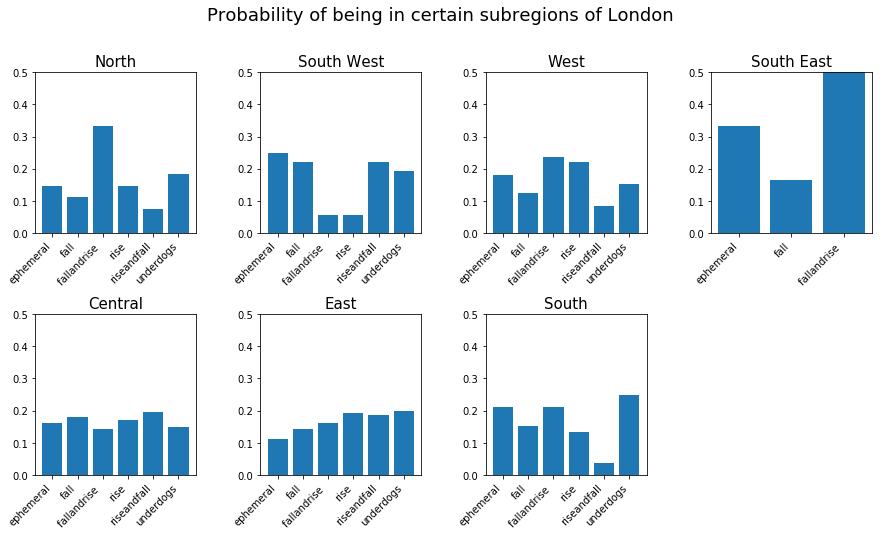

In [542]:
f, ax      = plt.subplots(2,4, figsize = (15,7))
indicies   = [(i,j) for i in range(2) for j in range(4)]
fig_order  = {'rise' : 0, 'fallandrise ' : 1, 'underdogs' : 2, 'fall' : 3, 'riseandfall' : 4, 'ephemeral' : 5 }
featuresCD = pd.DataFrame(features3[['WHERE_sub_region', 'LABEL_category']])

cardinaldirections = {  4: 'South East',
                        2: 'North',
                        5: 'South West',
                        6: 'West',
                        1: 'East',
                        3: 'South',
                        0: 'Central'}

subregions_data = {}

for ind, c in clustersids.items():
    
    bx     = ax[indicies[fig_order[c]]]
    df     = featuresCD[featuresCD.LABEL_category == ind]
    df     = df.groupby('WHERE_sub_region').count()
    x      = np.asarray(df.index)
    y      = dict(df.LABEL_category)#, dtype=np.float64)
    yall   = dict(featuresCD.groupby('WHERE_sub_region').count().LABEL_category) 
    ydata  = [ float(y[xx])/float(yall[xx]) for xx in x]
    

#    bx.bar([cardinaldirections[xx] for xx in x],ydata)
#    bx.set_xticklabels([cardinaldirections[xx] for xx in x], rotation = 30)
 #   bx.set_ylim([0.0, 0.55])
 #   bx.set_title(c, fontsize = 15)
    
    for ind, xx in enumerate(x):
        subr = cardinaldirections[xx]
        if subr not in subregions_data:
            subregions_data[subr] = [(c, ydata[ind])]
        else:
            subregions_data[subr].append((c, ydata[ind]))

    
for ind, (region, data) in enumerate(subregions_data.items()):
    
    bx   = ax[indicies[ind]]
    x, y = zip(*data)
    
    bx.bar(x,y)
    bx.set_title(region, fontsize = 15)
    bx.set_xticklabels(x, rotation = 45, ha = 'right')
    bx.set_ylim([0,0.5])
    

ax[1,3].axis('off')
    
plt.suptitle('Probability of being in certain subregions of London', fontsize = 18)
plt.subplots_adjust(top = 0.85, bottom=0.05, hspace=0.5, wspace=0.4)
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/subregions2.png')    

# MAP

In [490]:
ward_shp_df  = gpd.read_file('../wards/London-wards-2014_ESRI/London_Ward.shp').to_crs({'init': 'epsg:4326'})     
ward_shp_df.index = ward_shp_df.GSS_CODE
ward_shp_df.head()

all_ward = list(ward_shp_df.index)

In [548]:
city         = 'london'
datafile     = 'FINAL_DATA'
successdata  = datafile + '/london_venues_success_measures.csv'
ward_stats_f = datafile + '/venues_ward_full.dat'
ward_stats   = pd.read_csv(ward_stats_f, sep = '\t', index_col = 0)
ward_stats   = ward_stats[~ward_stats.index.duplicated(keep='first')]   
ward_stats   = ward_stats.rename(columns = {'ward' : 'GSS_CODE'})#.drop(['ward'], axis=1)
ward_stats   = pd.DataFrame(ward_stats.GSS_CODE)

ward_stats.head()

,GSS_CODE
venue,
4ed012c26c2510ace08f6196,E05000649
5131bfc3e4b021182eb750c3,E05000368
54075d1f498e92eeef450c56,E05000649
5214b8fb11d2f8576bfde883,E05000153
5260ef75498eda1e8cbc86b2,E05000138


In [557]:
features2GEO = features2.join(ward_stats)
features2GEO = features2GEO[['LABEL_category', 'GSS_CODE']]

df_results_full = pd.DataFrame()

for cl, cname in clustersids.items():   

    df     = features2GEO[features2GEO.LABEL_category == cl]
    df     = df.groupby('GSS_CODE').count()
    df_all = features2GEO.groupby('GSS_CODE').count()
       
    df_results = {}
    for ward in all_ward:
        try:
            df_results[ward] = float(df.loc[ward].LABEL_category) / float(df_all.loc[ward].LABEL_category)
        except:
            df_results[ward] = 0.0
            pass
    
    dfres = pd.DataFrame(df_results.items())
    dfres.index = dfres[0]
    dfres.index.name = 'GSS_CODE'
    dfres = dfres.drop(columns = [0])
    dfres = dfres.rename(columns = {1 : 'fraction_of_' + cname})
    
    
    if len(df_results_full) == 0:
        df_results_full = dfres
    else:     
        df_results_full = df_results_full.merge(dfres, right_index = True, left_index = True)
       


gdf_results_full = gdp.GeoDataFrame(df_results_full)
gdf_results_full = gdf_results_full.merge(ward_shp_df, right_index = True, left_index = True)
gdf_results_full = gdf_results_full.drop(columns = ['NAME', 'GSS_CODE','HECTARES','NONLD_AREA','LB_GSS_CD', 'BOROUGH'])
gdf_results_full




8183


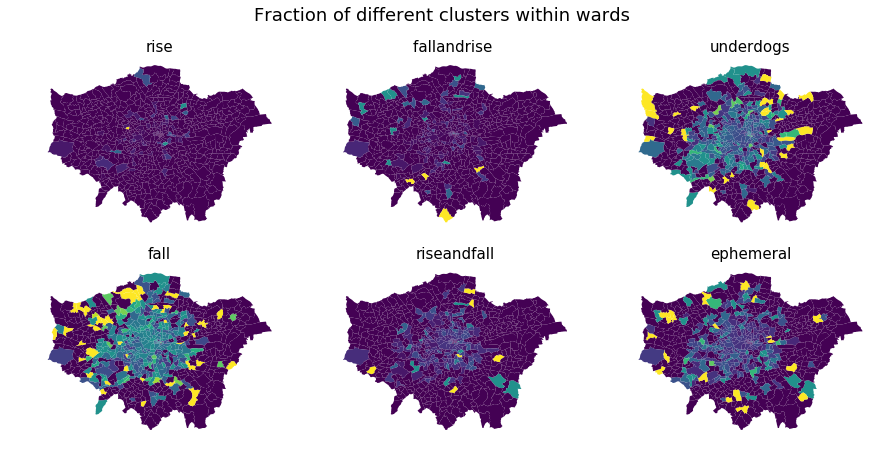

In [506]:
f, ax    = plt.subplots(2,3,figsize = (15,7))
indicies = [(i,j) for i in range(2) for j in range(3)]

for cl, cname in clustersids.items():   

    bx = ax[indicies[fig_order[cname]]]

    gdf_results_full.plot(column = 'fraction_of_' + cname, ax = bx)
    bx.set_title(cname, fontsize = 15)
    bx.axis('off')
    
    

plt.suptitle('Fraction of different clusters within wards', fontsize = 18)
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/map.png')    

# Popularity IMD Bohemian

In [588]:
venues_wards = ward_stats[ward_stats.index.isin(list(features2.index))]
venues_wards.head()

,GSS_CODE
venue,
54075d1f498e92eeef450c56,E05000649
4adb1f41f964a520742421e3,E05000173
4bf696bdabdaef3b324ba184,E05000264
4ac518c5f964a520f0a420e3,E05009392
4ac518b5f964a5208ca020e3,E05000649


In [658]:
demog_f     = datafile + '/london_wards_demographics.csv'
demog       = pd.read_csv(demog_f, sep = ',')
demog.index = demog.GSS_CODE
demog_ven   = venues_wards.merge(demog, left_on='GSS_CODE', right_on='GSS_CODE', right_index = True) #left_index=True, right_index=False)
demog_ven   = demog_ven.merge(pd.DataFrame(features2.LABEL_category), left_index = True, right_index = True)
demog_ven   = demog_ven.drop(columns = [c for c in demog_ven.keys() if c not in ['LABEL_category', 'PopDen', 'IMDScore', 'ArtsEmploy']])                                                 
demog_ven.head()

,ArtsEmploy,IMDScore,PopDen,LABEL_category
venue,,,,
54075d1f498e92eeef450c56,4600.0,20.48,5300.0,3
4ac518b5f964a5208ca020e3,4600.0,20.48,5300.0,5
4b0987eaf964a520e61823e3,4600.0,20.48,5300.0,4
519133a7498e6e48d1dafb24,4600.0,20.48,5300.0,5
4ad23218f964a520fedf20e3,4600.0,20.48,5300.0,0


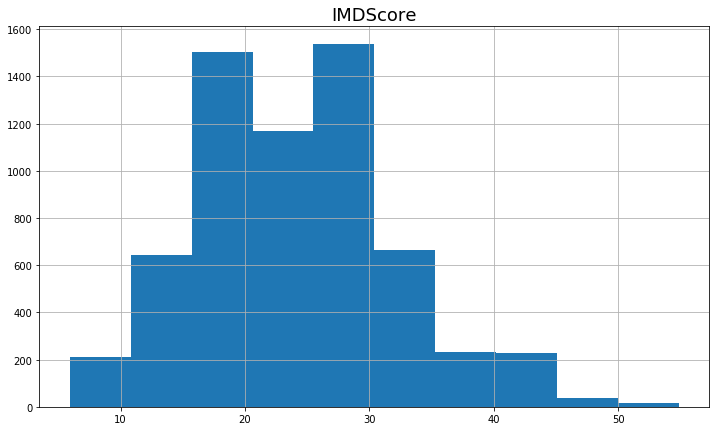

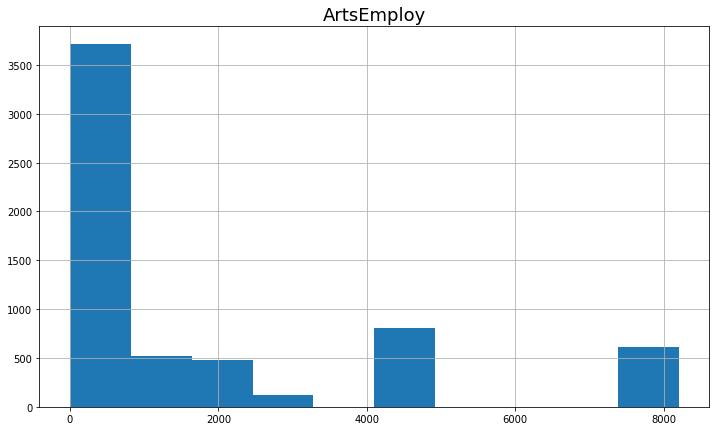

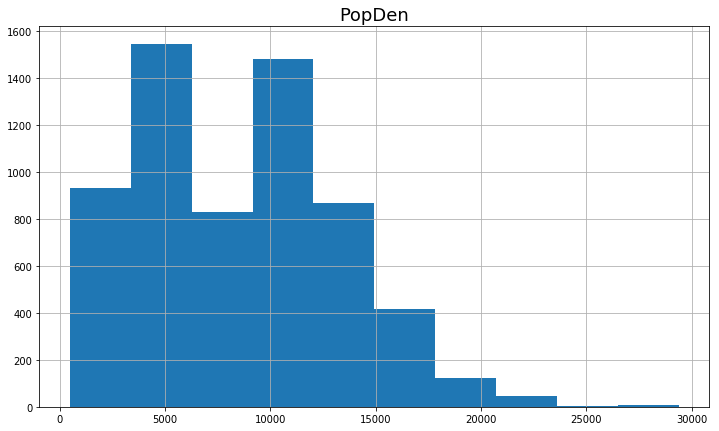

In [682]:
for meas in ['IMDScore', 'ArtsEmploy', 'PopDen']:

    f, ax = plt.subplots(1,1, figsize = (12,7))
    demog_ven[meas].hist(ax = ax)
    ax.set_title(meas, fontsize = 18)
    plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/ideas/' + meas + '_hist.png')            


ArtsEmploy
IMDScore
PopDen


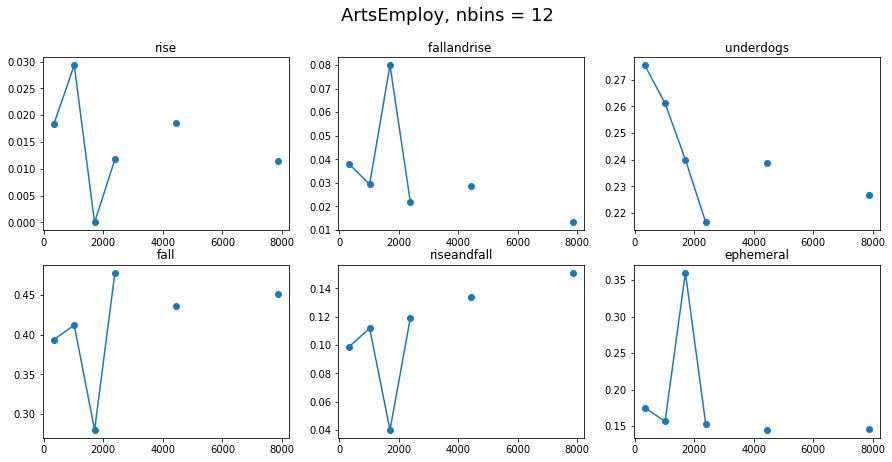

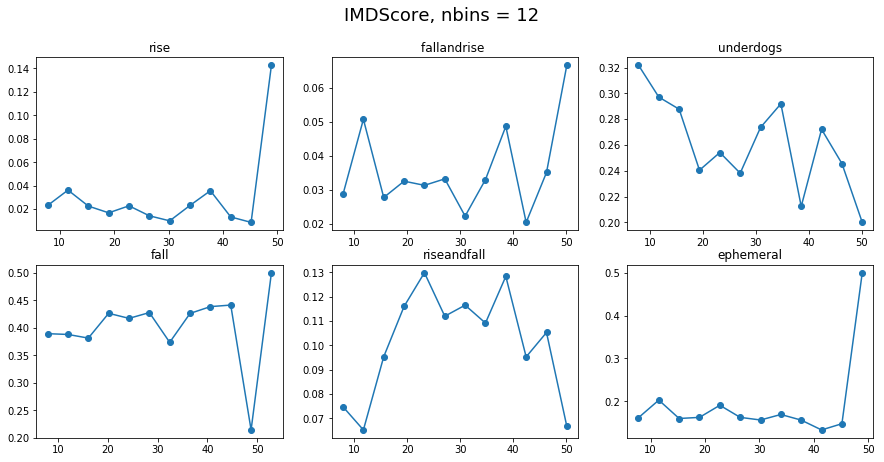

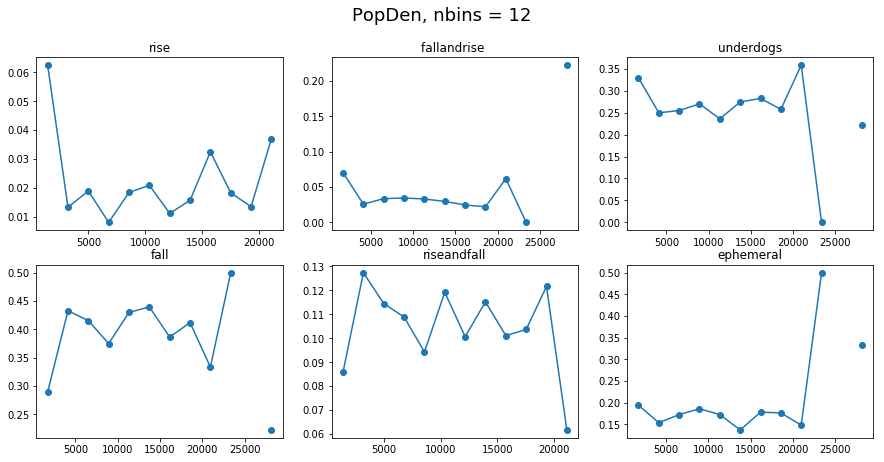

In [679]:
indicies  = [(i,j) for i in range(2) for j in range(3)]
nbins     = 12
measures  = [k for k in features.keys() if 'LABEL' not in k and 'WHO' not in k]
outfolder = 'PROBPLOTS'


cluster_names_size = {  1316 : 'Ephemeral',
                        3375 : 'Fall',
                        269  : 'Fall & Rise',
                        160  : 'Rise',
                        944  : 'Rise & Fall',
                        2119 : 'Underdogs'  }


for jind, measure in enumerate(demog_ven.keys()[0:3]):

    print measure
        
    f, ax = plt.subplots(2, 3, figsize = (15,7))
    f.suptitle(measure + ', nbins = ' +  str(nbins), fontsize = 18)

    for cl, cname in clustersids.items():
        
        bx          = ax[indicies[fig_order[cname]]]
        df_meas_all = pd.DataFrame(demog_ven[[measure, 'LABEL_category']])#.fillna(0)
        df_meas     = df_meas_all
        df_cluster  = df_meas[df_meas.LABEL_category == cl]

        n,  bins      = np.histogram(df_cluster[measure],  bins=nbins)
        Nn, Nbins     = np.histogram(df_meas[measure],     bins)
        probabilities = np.asarray(n, dtype=np.float64)/np.asarray(Nn, dtype=np.float64)
        bins          = ( bins[1:] + bins[:-1] ) / 2.0                 

        
        bx.plot(bins, probabilities, 'o-')    
        bx.set_title(cname)
        
  
    plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/ideas/' + measure + '_' + str(nbins) + '.png')            
#plt.subplots_adjust(top = 0.95, bottom=0.05, hspace=0.5, wspace=0.4)
#plt.tight_layout()          

# BARPLOT STUFFS

1.0

In [139]:
def xgb_model_params_1vsall(X, y, targetcluster, max_depth_, learning_rate_, subsample_):
           

    
    y_= [1 if yy == targetcluster else 0 for yy in y]
        
    train_data, test_data, train_label, test_label =  train_test_split(X, y_, test_size=.33, random_state=42)    
           
    model2       = xgb.XGBClassifier(n_estimators=1000, max_depth=max_depth_, learning_rate=learning_rate_, subsample=subsample_)
    train_model2 = model2.fit(train_data, train_label)
    pred2        = train_model2.predict(test_data)
        
    featurenames, importances = zip(*sorted(zip(train_data.keys(), model2.feature_importances_), key=lambda tup: tup[1], reverse = True))
    #print accuracy_score(test_label, pred2) * 100
    
    
    #for i in range(len(featurenames)):
     
     #   print targetcluster,'\t', featurenames[i], '\t', importances[i]
    
    return featurenames, importances 
 


classes_features = {}
    
    
for trgcl in range(9):
    
    featurenames, importances = xgb_model_params_1vsall(X, y, trgcl, 5, 0.05, 0.75)
    
    classes_features[clustersids[trgcl]]  = {}
    
    for i in range(len(featurenames)):
        classes_features[clustersids[trgcl]][featurenames[i]] = importances[i]
    
    
    
    print '\n'



KeyError: 6

In [ ]:
clustersids



In [ ]:
a = [(0,'Birth date',0.1475128),
(0,'Avg buying power',0.14022298),
(0,'Category uniqueness',0.13904373),
(1,'Avg buying power',0.15942338),
(1,'Birth date',0.14660972),
(1,'Category uniqueness',0.14212494),
(2,'Avg buying power',0.15805697),
(2,'Birth date',0.14817177),
(2,'Category uniqueness',0.13435374),
(3,'Category uniqueness',0.14690147),
(3,'Avg buying power',0.14567544),
(3,'Fraction of females',0.14054838),
(4,'Birth date',0.16421354),
(4,'Avg buying power',0.15268014),
(4,'Fraction of females',0.14883567),
(5,'Avg buying power',0.15689884),
(5,'Birth date',0.1480004),
(5,'Fraction of females',0.142068129)]

In [ ]:
set([aa[1] for aa in a])

In [ ]:
classes_features

In [189]:
colors_d = { 'WHO'   : '#e41a1c',
             'WHERE' : '#377eb8',
             'WHAT'  : '#984ea3',
             'WHEN'  : '#4daf4a', 
             'ALL'   : 'grey'}    
    
    
colors = [[colors_d['WHEN'],  colors_d['WHO'],  colors_d['WHERE']], 
          [colors_d['WHO'],  colors_d['WHEN'],  colors_d['WHERE']],
          [colors_d['WHERE'], colors_d['WHO'],  colors_d['WHO']]]
  

    
colors2 = [[colors_d['WHO'],  colors_d['WHEN'],  colors_d['WHERE']], 
          [colors_d['WHEN'],  colors_d['WHO'],  colors_d['WHO']],
          [colors_d['WHO'], colors_d['WHEN'],  colors_d['WHO']]]    
    
colors

[['#4daf4a', '#e41a1c', '#377eb8'],
 ['#e41a1c', '#4daf4a', '#377eb8'],
 ['#377eb8', '#e41a1c', '#e41a1c']]

In [ ]:
f, ax = plt.subplots(1,3,figsize = (15,5.5))

axid = 0

for ind, (clusterid, name, value) in enumerate(a):
    
    cluster = clustersids[clusterid]    
    
    if cluster in ['underdogs', 'fallandrise ', 'riseandfall']:
        if ind % 3 == 0:
            x = []
            y = []        

        x.append(name)
        y.append(value)

        
        if len(x) == 3:
            bx = ax[axid]
            bx.bar(x,y, width = 0.4, color = colors2[axid], alpha = 0.75, align='center')
            bx.set_title(cluster.title(), fontsize = 20)
        

            bx.grid('off')
            for pos in ['right', 'top']:
                bx.spines[pos].set_edgecolor('white')
                
            bx.set_ylim([0.1,0.17])    

            for pos in ['bottom', 'right', 'top', 'left']:
                bx.spines[pos].set_edgecolor('white')
            
            bx.yaxis.grid(linewidth = 0.25) 

            bx.tick_params(axis='x', length=0, width=1,   colors='k')
            bx.tick_params(axis='y', length=4, width=1.5, colors='k')
            bx.set_xticks(x)


            [t.set_color(i) for (i,t) in zip(colors2[axid],bx.xaxis.get_ticklabels())]
            bx.set_xticklabels([xxxx.replace(' f', '\nf').replace(' u', '\nu').replace(' p', '\np') for xxxx in x], rotation = 45, fontsize = 14, ha = 'center')

     
            axid += 1


plt.subplots_adjust(top = 0.95, bottom=0.1, hspace=0.4, wspace=0.95)
plt.tight_layout()

plt.savefig('FINAL_FIGURES/clusters_pred2.png')
  

In [ ]:
p = [(0, 'Peak hour', 0.067645796),
    (2, 'Peak hour', 0.0766369),
    (1, 'Peak hour', 0.078056596),
    (4, 'Peak hour', 0.08172232),
    (3, 'Peak hour', 0.08403923),
    (5, 'Peak hour', 0.08519996)]


d = [(0, 'Distane from the Center', 0.07847341),
    (1, 'Distane from the Center', 0.066417515),
    (2, 'Distane from the Center', 0.088541664),
    (3, 'Distane from the Center', 0.07567989),
    (4, 'Distane from the Center', 0.05700791),
    (5, 'Distane from the Center', 0.07118748)]

c = [(0  , 'Network constraint',  0.021548027 ),
(1  , 'Network constraint',  0.0118526425 ),
(2  , 'Network constraint',  0.020089285 ),
(3  , 'Network constraint',  0.012371823 ),
(4  , 'Network constraint',  0.0068101934 ),
(5  , 'Network constraint',  0.0076710647 )]



In [ ]:
clustersids

In [ ]:
f, ax = plt.subplots(2,1, figsize = (15,8))


px, py, pz = zip(*p)

ax[0].tick_params(axis='x', length=0, width=1,   colors='k')
ax[0].tick_params(axis='y', length=4, width=1.5, colors='k')
ax[0].bar(range(len(pz)), pz, alpha = 0.75, width = 0.3, color  = colors_d['WHEN'])
ax[0].set_ylim([0.055, 0.09])
ax[0].set_xticks(px)

xticklabels = []
for  i in px:
    if 'and' not in clustersids[i]:
        xticklabels.append(clustersids[i].title())
    else:
        xticklabels.append(clustersids[i].replace('and', ' & ').title())
    
    
ax[0].set_xticklabels(xticklabels, fontsize = 14)


ax[0].set_title('importance of PEAK HOURS', fontsize = 20)
ax[0].grid('off')
for pos in ['bottom', 'right', 'top', 'left']:
    ax[0].spines[pos].set_edgecolor('white')

ax[0].yaxis.grid(linewidth = 0.25) 
ax[0].set_xticks(range(6))


for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 



''' ===============================    '''


d_sort = sorted(c, key=lambda tup: tup[2])
dx, dy, dz = zip(*d_sort)

ax[1].bar(range(len(dz)), dz, alpha = 0.75, width = 0.3, color  = colors_d['WHERE'])
ax[1].set_ylim([0.0, 0.025])
ax[1].set_xticks(dx)
ax[1].set_xticklabels([clustersids[i] for i in dx ])




xticklabelsss = []
for  i in dx:
    if 'and' not in clustersids[i]:
        xticklabelsss.append(clustersids[i].title())
    else:
        xticklabelsss.append(clustersids[i].replace('and', ' & ').title())
    
    
    
    


ax[1].set_title('importance of NETWORK CONSTRAINT', fontsize = 20)
ax[1].grid('off')
for pos in ['bottom', 'right', 'top', 'left']:
    ax[1].spines[pos].set_edgecolor('white')

ax[1].yaxis.grid(linewidth = 0.25)     


ax[1].set_xticks(range(6))

ax[1].set_xticklabels(xticklabelsss, fontsize = 14)



for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 



plt.savefig('FINAL_FIGURES/featcompar.png')

In [ ]:
features = classes_features['ephemeral'].keys()


for feat in features:
    

    x = []
    y = []
    
    for cl, cldata in classes_features.items():
        x.append(cl) 
        y.append(cldata[feat])
        
        
    xy      = [(x[i], y[i]) for i in range(len(x))]    
    xy_sort = sorted(xy, key=lambda tup: tup[1])    
    dx, dy  = zip(*xy_sort)
  

    coeff =  (max(dy)- min(dy)) / max(dy)
    
    if  coeff > 0.21:

        f, ax = plt.subplots(1,1, figsize = (15,6))


        ax.bar(dx,dy, alpha = 0.75, width = 0.3, color  = colors_d[feat.split('_')[0]])
        ax.set_title(feat, fontsize = 18)



        ax.set_title(feat, fontsize = 20)
        ax.grid('off')
        for pos in ['bottom', 'right', 'top', 'left']:
            ax.spines[pos].set_edgecolor('white')

        ax.yaxis.grid(linewidth = 0.25)     


        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 

        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
            
        ax.set_ylim([max(dy) / 2, max(dy)*1.1])    
        ax.set_ylabel('Relative importance', fontsize = 16)    
            
        f.savefig('FINAL_FIGURES/differences_' + feat + '.png')
        plt.close()

       
       